# Mel Spectrogram Generation Demo

This is a demo on utilising the librosa library to perform mel spectrum analysis. Librosa is a very mature and well documented speech processing library. Documentation can be found at: https://librosa.org/doc/latest/index.html

Let's us put in the necessary imports for this demo. We will need librosa itself, a librosa plotting utility, numpy (of course), and matplotlib, the de-facto standard Python plotting library.

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

Now, we shall be tinkering with a sample wav file. We will need to define the path to it for this demo to work.

In [11]:
!ls

lec1demo.wav			  mock_es.flac
lecture1_melspectrum.ipynb	  speech_gan_assignment.ipynb
lecture2_mel_cnnclassifier.ipynb


In [12]:
# path to wav file
speech_file = 'lec1demo.wav'
speech_file = 'mock_es.flac'

If you recall in our lecture, we need to define a frame size, since FFT-based algorithms require this to be set. Our speech has been recorded at a sampling rate of 16,000 samples per second. We shall pick a frame size of 512 samples i.e. 512/16000 of a second, approximately 32 milliseconds.

In [13]:
# define some constants
mel_spec_frame_size = 512 # 512 samples in frame = 512/fs milliseconds per frame

In order to use librosa to load a wav file, we need the 'load' API call (https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load)

At the very least, we need the path to the file, which we have already. The second parameter in the API call, 'sr', refers to the sampling rate at which the file is to be loaded. By default, librosa sets this to 22,050 samples per second. Therefore, if we leave the default as is, and if our file does not have a sampling rate of 22050 samples per second, librosa will resample (either by upsampling or downsampling) the audio for you.

Whilst it is always good practice to have the same sampling rate for all our wav files when running experiments, we do not wish to sample at such a high rate. In fact, for this demo, we do not wish to resample at all. In order to explicitly declare this, the 'sr' parameter should be set to None. Alternatively, if you want to make sure all your files will always be processed at 16,000 samples per second, you can set this parameter accordingly.

Let us go ahead and load up our audio file.

In [14]:
sig, fs = librosa.load(speech_file,sr=None)  # or sr=16000
print(fs)

22050


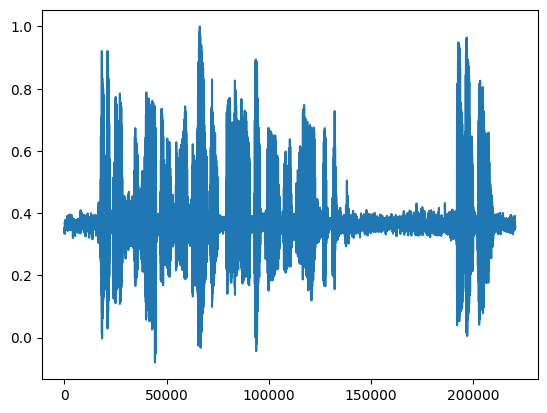

In [22]:
# testing signal
plt.plot(sig)

In [15]:
print(sig)
print(sig.shape)

[0.11798096 0.11758423 0.11749268 ... 0.11993408 0.12017822 0.12017822]
(220500,)


Two parameters are returned:
- 'sig' contains the raw samples of the wav file
- 'fs' is the sampling rate at which sig is sampled. We have printed this out, and as you can see, the file is sampled at 16,000 samples per second.

Once our wav file is loaded, it is quite simple to use librosa to generate a Mel spectrogram. A lot of the signal processing complexities are entirely hidden from you.

The API call for a Mel spectrogram is defined in https://librosa.org/doc/latest/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram

The parameters we need are:
- 'y' the signal samples themselves
- 'sr' the sampling rate of the signal
- 'nfft' the size, in samples, of a frame (we decided this would be 512 samples earlier on)
- 'hop_length' the size, in samples of how far to advance to process the next frame. This is nominally 50% of nfft.
- 'n_mels' the number of triangular filters along the filterbank covering the entire frequency range.
- 'center' when set to True, the signal 'y' is padded so that frame 't' is centered at y[t*hop_length]. This is highly suggested.

In [16]:
melspec = librosa.feature.melspectrogram(y=sig,
                                         sr=fs,
                                         center=True,
                                         n_fft=mel_spec_frame_size,
                                         hop_length=int(mel_spec_frame_size/2),
                                         n_mels=128)

Now that we can generate a Mel spectrogram easily, let's do some plotting. Librosa helps with plotting as well (in tandem with matplotlib). It takes care of scaling the x/y axes with the right units as spacing between units. All we need to do is embed the plot within a standard Python plot.

Librosa provides a 'specshow' API call (https://librosa.org/doc/latest/generated/librosa.display.specshow.html?highlight=specshow#librosa.display.specshow). It just needs the mel spectrum variable we just extracted, and an indication that this spectrum is actual a Mel type (not an FFT type) spectrum, defined in the 'y_axis' parameter. Further more, since we know that the maximum possible frequency we can see on a spectrum is never more than half the sampling frequency of a signel (Nyquist-Shannon Sampling Theorem), then we set the 'fmax' to this value. We also instruct the call to show time on the 'x_axis'.

Another thing to notice is that instead of passing the raw mel spectrum information to 'specshow', we are using librosa to convert the power values into dB (decibels), a standard measure of loudness in acoustics and speech in general.

The other parameters make reference to the same set of parameters you have seen earlier, and should be matched.

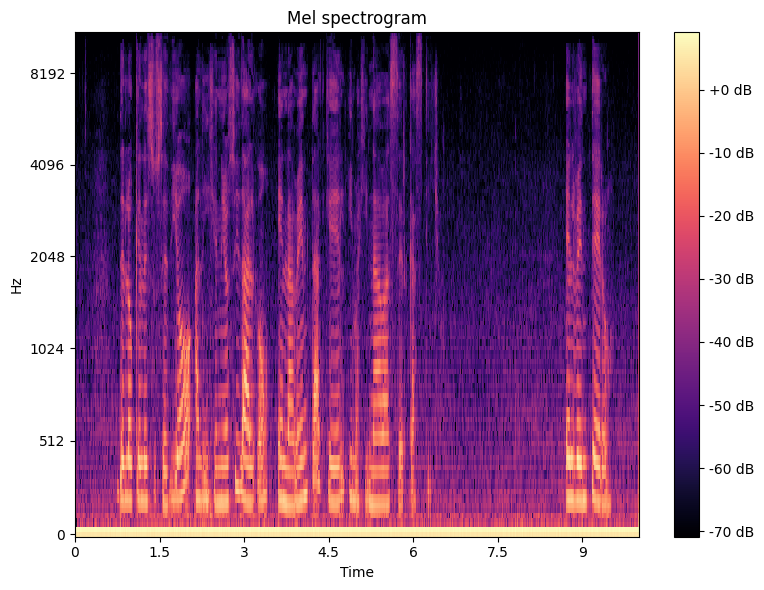

In [17]:
plt.figure(figsize=(8, 6))
plt.xlabel('Time')
plt.ylabel('Mel-Frequency')
librosa.display.specshow(librosa.power_to_db(melspec, ref=1.0),
                         y_axis='mel',
                         fmax=fs/2,
                         sr=fs,
                         hop_length=int(mel_spec_frame_size/2),
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

You can now experiment a bit, perhaps by trying to generate a Mel spectrogram with more filters. If we replace the previous value of 'n_mels' to 128 from 64, we should get a higher resolution image. Try it out.

Now that we know how to extract a Mel-spectrogram and plot it, let's add some additional pre-processing that you will find useful later on. The first step is to normalize the signal data (the raw samples) in a range. A most useful range is [-1.0, 1.0]. This is an easy one-liner in Python:

In [18]:
# Normalize audio to between -1.0 and +1.0
sig /= np.max(np.abs(sig), axis=0)

Furthermore, it would be nice to always have signals of the same length. The example above is just over 0.6 seconds. We can lengthen the data to always contain 1 full second of data by zero-padding the signal.

In [19]:
if len(sig) < fs: # pad if less than a second
    shape = np.shape(sig)
    padded_array = np.zeros(fs)
    padded_array[:shape[0]] = sig
    sig = padded_array

That's all we need to create a neat function that pre-processes our data, and returns a Mel spectrogram, and otionally plots it:

In [20]:
def get_melspec_from_wav(wavfile, n_mels=64, plot=False):
    """
    Given a path to a wav file, returns a melspectrogram array.
    np.ndarray [shape=(n_mels, t)]
    :param wavfile: The input wav file.
    :param n_mels: The number of mel spectrogram filters.
    :param plot: Flag to either plot the spectorgram or not.
    :return: Returns a tuple of np.ndarray [shape=(n_mels, t)] and fs
    """
    sig, fs = librosa.load(wavfile,sr=None)

    # Normalize audio to between -1.0 and +1.0
    sig /= np.max(np.abs(sig), axis=0)

    if len(sig) < fs: # pad if less than a second
        shape = np.shape(sig)
        padded_array = np.zeros(fs)
        padded_array[:shape[0]] = sig
        sig = padded_array

    melspec = librosa.feature.melspectrogram(y=sig,
                                             sr=fs,
                                             center=True,
                                             n_fft=mel_spec_frame_size,
                                             hop_length=int(mel_spec_frame_size/2),
                                             n_mels=n_mels)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.xlabel('Time')
        plt.ylabel('Mel-Frequency')
        librosa.display.specshow(librosa.power_to_db(melspec, ref=1.0),
                                 y_axis='mel',
                                 fmax=fs/2,
                                 sr=fs,
                                 hop_length=int(mel_spec_frame_size / 2),
                                 x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel spectrogram')
        plt.tight_layout()
        plt.show()

    return melspec, fs

Using the function is trivial.

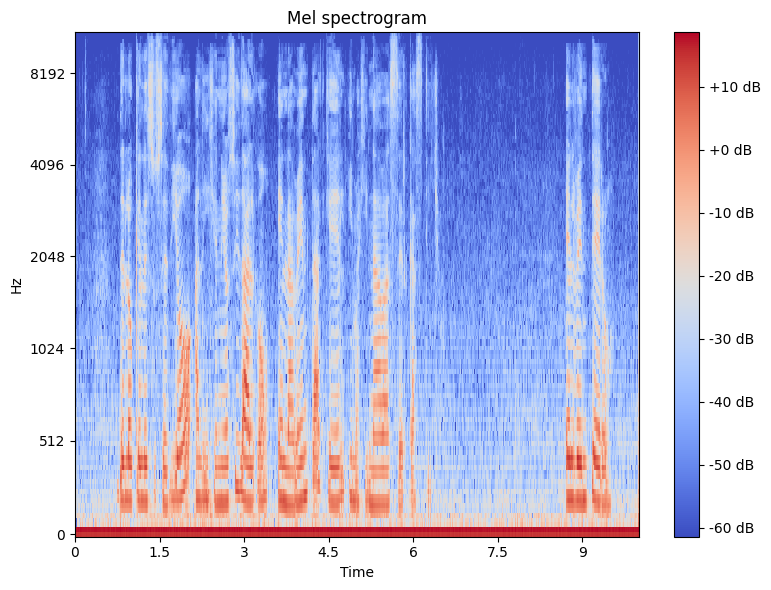

In [21]:
melspec, fs = get_melspec_from_wav(wavfile=speech_file,
                                   plot=True,
                                   n_mels=128)

# Signal Reconstruction
Now that we know how to obtain a Mel spectrogram, we will look into reconstructing the 'original' audio from the spectrum. Unfortunately, the spectrum is actually compressing some of the information, so complete recovery is not possible, and some deterioration in quality is to be expected.

Nevertheless, librosa makes this operation easy with the 'mel_to_audio' API call (https://librosa.org/doc/main/generated/librosa.feature.inverse.mel_to_audio.html). All we need is to rememebr the parameters we used for generating the Mel spectrogram in the first place, and we can get a signal back:

In [18]:
sig_recovered = librosa.feature.inverse.mel_to_audio(M=melspec,
                                           sr=fs,
                                           center=True,
                                           n_fft=mel_spec_frame_size,
                                           hop_length=int(mel_spec_frame_size/2))

# Normalize audio to between -1.0 and +1.0
sig_recovered /= np.max(np.abs(sig_recovered), axis=0)

Once we have our signal back, we can plot it:

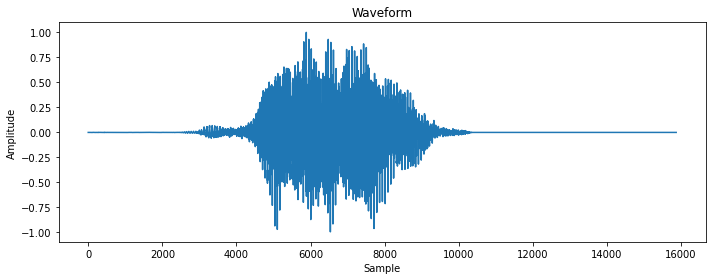

In [19]:
plt.figure(figsize=(10, 4))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(sig_recovered)
plt.title('Waveform')
plt.tight_layout()
plt.show()

Seeing is believing, but when it comes to speech, we really should be listening. Let's play back the original and recovered audio for comparison. We first need an import to play audio in this notebook.

In [20]:
import IPython.display as ipd

We now can play the original audio:

In [21]:
ipd.Audio(sig, rate=fs) # play original signal

As well as the recovered signal:

In [22]:
ipd.Audio(sig_recovered, rate=fs) # play recovered signal

The last Mel spectrum we generated had 128 Mel filters applied. Try going back down to 64, and reconstruct the audio. What can you notice?

# Homework

This concludes today's demo. As a first task for your assignment, you are required to extend the functionality we covered today to:
1. Read wav files, converting them to Mel spectra (using the function we wrote today)
2. Convert the Mel Spectrum from power values to dB
3. Scale/normalize the dB-based Mel Spectrum by the highest dB value (the default used in the power_to_db API call is 80.0)
4. Check if the Mel spectrum conforms to 64 time samples (over 1 second), and if not, pad the Mel spectrum accordingly.
5. Save the Mel spectrum as an NPY or NPZ file.
6. Furthermore, save the Mel spectrum as a PNG image.
7. Reconstruct the audio from the Mel spectrum data (we have written most of the code for this already, but since you are scaling the dB values to save them to disk, you will need to scaled them back up to the original dB values (with a multiplication by highest dB value)

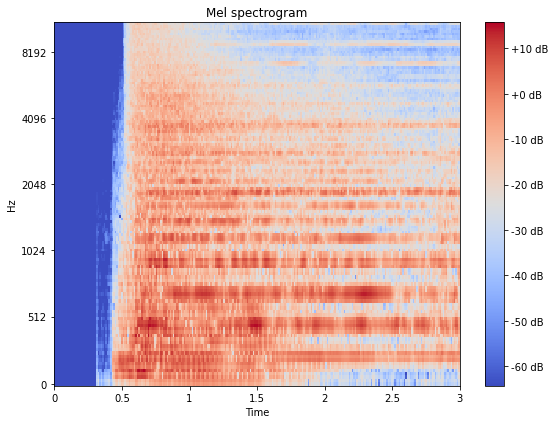

In [57]:
starwars = "StarWars3.wav"
mel_spec_frame_size = 512 
melspec, fs = get_melspec_from_wav(starwars, n_mels=128, plot=True)

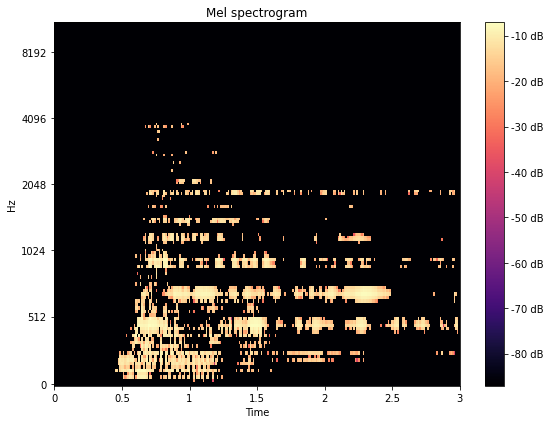

In [58]:
high_db = 80.0
melspec = librosa.power_to_db(melspec, ref=1.0)
melspec = melspec / high_db
plt.figure(figsize=(8, 6))
plt.xlabel('Time')
plt.ylabel('Mel-Frequency')
librosa.display.specshow(librosa.power_to_db(melspec, ref=1.0),
                         y_axis='mel',
                         fmax=fs/2,
                         sr=fs,
                         hop_length=int(mel_spec_frame_size / 2),
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [68]:
print(melspec.shape)  # cols will be the n_mels, this is looking at the samples
if melspec.shape[1] < 64:
    shape = np.shape(melspec)    
    padded_array = np.zeros((shape[0], 64)) - 1        
    padded_array[0:shape[0],:shape[1]] = melspec
    melspec = padded_array    

(128, 259)


In [73]:
def save_image(filepath, fig=None):
    '''Save the current image with no whitespace
    Example filepath: "myfig.png" or r"C:\myfig.pdf"
    '''
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0,0,1,1,0,0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0,0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(filepath, pad_inches = 0, bbox_inches='tight')

# save melspec
melspec_filename = (os.path.join('.', starwars)).replace('.wav', '.mel')
np.savez(melspec_filename, melspec=melspec, fs=fs)

# save melspec image
melspec_image_filename = (os.path.join('.', starwars)).replace('.wav', '.png')
fig = plt.figure(figsize=(10, 4))
plt.imshow(melspec, origin='lower')
plt.tight_layout()
save_image(filepath=melspec_image_filename,fig=fig)
plt.close()

In [76]:
melspec = melspec * high_db
sig_recovered = librosa.feature.inverse.mel_to_audio(M=melspec,
                                           sr=fs,
                                           center=True,
                                           n_fft=mel_spec_frame_size,
                                           hop_length=int(mel_spec_frame_size/2))

# Normalize audio to between -1.0 and +1.0
sig_recovered /= np.max(np.abs(sig_recovered), axis=0)



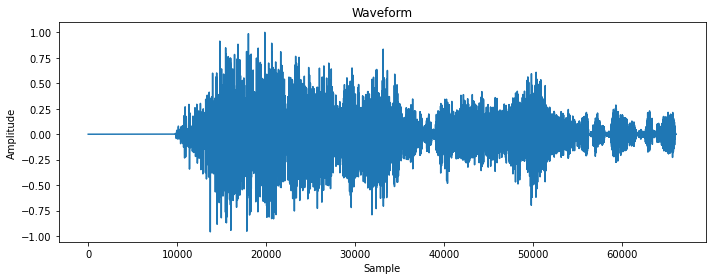

In [77]:
plt.figure(figsize=(10, 4))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.plot(sig_recovered)
plt.title('Waveform')
plt.tight_layout()
plt.show()

In [81]:
sig, fs = librosa.load(starwars, sr=None)

# Normalize audio to between -1.0 and +1.0
sig /= np.max(np.abs(sig), axis=0)
ipd.Audio(sig, rate=fs)

In [78]:
ipd.Audio(sig_recovered, rate=fs)